# Probabilistic Programming - 2: Mixture modeling
## Variational inference

In this notebook, we are exploring a more complex problem set using variational inference, namely mixture modeling. It will show you how to deal with the multivariate case.

### Preliminaries

- Goal 
  - Write a variational inference procedure for a 2-dimensional mixture model.
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - Getting started with [ForneyLab](https://biaslab.github.io/forneylab/docs/getting-started/).
    - [Demos in ForneyLab](https://github.com/biaslab/ForneyLab.jl/tree/v0.10.0/demo)
    - Cheatsheets: [how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

In [1]:
# Package managing
# using Pkg
# Pkg.activate("workspace")
# Pkg.instantiate()

using Logging; disable_logging(LogLevel(0))
using StatsPlots
using LaTeXStrings
import Distributions: MvNormal

## Data generation

We generate samples from three 2-dimensional Gaussian distributions and mix these. These Gaussians are:

$$
\begin{align*}
\mathcal{N}_1(\begin{bmatrix}-2, -2 \end{bmatrix}, \begin{bmatrix}1 & 0 \\0 & 3 \end{bmatrix}) \, , \quad
\mathcal{N}_2(\begin{bmatrix}+2, +2 \end{bmatrix}, \begin{bmatrix}3 & 0 \\0 & 1 \end{bmatrix}) \, , \quad
\mathcal{N}_3(\begin{bmatrix}-2, +2 \end{bmatrix}, \begin{bmatrix}1 & 0 \\0 & 1 \end{bmatrix}) \, .
\end{align*}
$$

We draw $N_1$, $N_2$ and $N_3$ samples from each, respectively.

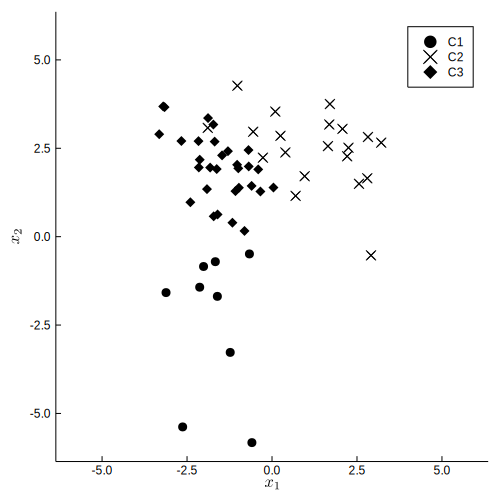

In [2]:
# Sample size
N1 = 10
N2 = 20
N3 = 30

# Parameters for each cluster
μ1 = [-2. -2.]
Σ1 = [1.0 0.0; 0.0 3.0]
μ2 = [+2. +2.]
Σ2 = [3.0 0.0; 0.0 1.0]
μ3 = [-2. +2.]
Σ3 = [1.0 0.0; 0.0 1.0]

function generate_data(means::Array{Float64,2}, covariances::Array{Float64,3}; num_samples::Array{Int64,1}=[10])
    "Generate data from a 2-dimensional mixture model"
    
    # Extract number of components
    K = length(num_samples)
    
    # Extract dimensionality
    D = size(covariances)[1]
    
    # Preallocate vectors
    X = zeros(sum(num_samples), D)
    C = zeros(sum(num_samples),)
    
    # Create sample index
    ix = cat(0, cumsum(num_samples), dims=1)
    
    for k = 1:K
        
        # Current indices
        ix_k = (ix[k]+1:ix[k+1])
    
        # Sample from cluster component
        X[ix_k, :] = rand(MvNormal(means[k,:], covariances[:,:,k]), num_samples[k])'
        
        # Store cluster origin
        C[ix_k,] = k*ones(num_samples[k])
        
    end
    
    return X, C
end

# Generate data
observations, cluster = generate_data(cat(μ1, μ2, μ3, dims=1), cat(Σ1, Σ2, Σ3, dims=3), num_samples=[N1, N2, N3])

# Total sample size
N = sum([N1, N2, N3])

# Visualization
scatter(observations[cluster .== 1, 1], observations[cluster .== 1, 2], marker=:circle, color="black", label="C1")
scatter!(observations[cluster .== 2, 1], observations[cluster .== 2, 2], marker=:xcross, color="black", label="C2")
scatter!(observations[cluster .== 3, 1], observations[cluster .== 3, 2], 
         marker=:diamond,
         color="black", 
         label="C3", 
         xlabel=L"$x_1$", 
         ylabel=L"$x_2$", 
         xlim=[-6, 6], 
         ylim=[-6, 6], 
         size=(500,500),
         grid=false)

### Model Specification

In [3]:
using ForneyLab

g = FactorGraph()

# Specify generative model
@RV phi ~ Beta(1.0, 1.0)
@RV m_1 ~ GaussianMeanVariance([0.0, 0.0], [1. 0.; 0. 1.])
@RV W_1 ~ Wishart([1. 0.; 0. 1.], 2.)
@RV m_2 ~ GaussianMeanVariance([0.0, 0.0], [1. 0.; 0. 1.])
@RV W_2 ~ Wishart([1. 0.; 0. 1.], 2.)

z = Vector{Variable}(undef, N)
y = Vector{Variable}(undef, N)
for i = 1:N
    @RV z[i] ~ Bernoulli(phi)
    @RV y[i] ~ GaussianMixture(z[i], m_1, W_1, m_2, W_2)
    
    placeholder(y[i], :y, dims=(2,), index=i)
end

Now, you need to specify a distribution with which you will approximate the posterior distribution that you would normally obtain through exact Bayesian inference.

In [4]:
# Specify recognition factorization (mean-field)
q = RecognitionFactorization(phi, m_1, W_1, m_2, W_2, z, ids=[:PHI, :M1, :W1, :M2, :W2, :Z])

# Generate the algorithm
algo = variationalAlgorithm(q)
algo_F = freeEnergyAlgorithm(q);

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algo_F));

Now, we execute the inference algorithm.

In [5]:
# Convert data to a format suited to ForneyLab
observed_ = [observations[i,:] for i in 1:N]

# Add to data dictionary
data = Dict(:y => observed_)

# Prepare recognition distributions
marginals = Dict(:phi => ProbabilityDistribution(Beta, a=1.0, b=1.0),
                 :m_1 => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[-1.0, +1.0], v=1e4*[1. 0.;0. 1.]),
                 :W_1 => ProbabilityDistribution(MatrixVariate, Wishart, v=10*[1. 0.;0. 1.], nu=2.),
                 :m_2 => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[+1.0, -1.0], v=1e4*[1. 0.;0. 1.]),
                 :W_2 => ProbabilityDistribution(MatrixVariate, Wishart, v=10*[1. 0.;0. 1.], nu=2.))
for i = 1:N
    marginals[:z_*i] = ProbabilityDistribution(Bernoulli, p=1/2.)
end

# Execute algorithm
num_iterations = 20
F = Float64[]
for i = 1:num_iterations
    
    stepZ!(data, marginals)
    stepM1!(data, marginals)
    stepW1!(data, marginals)
    stepM2!(data, marginals)
    stepW2!(data, marginals)
    stepPHI!(data, marginals)
        
    # Store variational free energy for visualization
    push!(F, freeEnergy(data, marginals))
end

┌ Warning: `lbeta(x::Real, w::Real)` is deprecated, use `(logabsbeta(x, w))[1]` instead.
│   caller = averageEnergy(::Type{Beta}, ::ProbabilityDistribution{Univariate,Beta}, ::ProbabilityDistribution{Univariate,PointMass}, ::ProbabilityDistribution{Univariate,PointMass}) at beta.jl:92
└ @ ForneyLab /home/wmkouw/.julia/packages/ForneyLab/Hz4kD/src/factor_nodes/beta.jl:92
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = (::ForneyLab.var"#69#70"{ProbabilityDistribution{Univariate,PointMass}})(::Int64) at none:0
└ @ ForneyLab ./none:0
┌ Warning: `lbeta(x::Real, w::Real)` is deprecated, use `(logabsbeta(x, w))[1]` instead.
│   caller = differentialEntropy(::ProbabilityDistribution{Univariate,Beta}) at beta.jl:84
└ @ ForneyLab /home/wmkouw/.julia/packages/ForneyLab/Hz4kD/src/factor_nodes/beta.jl:84
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = (::ForneyLab.var"#65#67"{ProbabilityDistribution{MatrixVariat

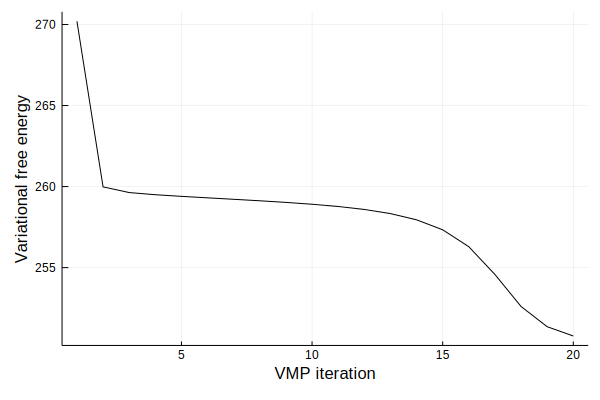

In [6]:
# Plot free energy to check for convergence
plot(1:num_iterations, F, color="black", label="")
xlabel!("VMP iteration")
ylabel!("Variational free energy")

Visualize the results.

In [7]:
include("../scripts/pp-2.jl")

# Estimated means
μ1_estimated = mean(marginals[:m_1])
μ2_estimated = mean(marginals[:m_2])
v1_estimated = var(marginals[:m_1])
v2_estimated = var(marginals[:m_2])
Σ1_estimated = cholinv(mean(marginals[:W_1]))
Σ2_estimated = cholinv(mean(marginals[:W_2]))

# Plot data and overlay estimated posterior probabilities
plot_posteriors(X, μ1_estimated, μ2_estimated, Σ1_estimated, Σ2_estimated; x1=range(-10,stop=10), x2=range(-10,stop=10))

ErrorException: mean(𝒩(xi=[1.32, 1.01e+02], w=[[14.99, 2.61][2.61, 46.78]])
) is undefined because the distribution is improper.